In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from ansys.mapdl.core import launch_mapdl
from ansys.mapdl import reader as pymapdl_reader

In [2]:
# Start an MAPDL instance
mapdl = launch_mapdl()

In [3]:
mapdl.finish()
mapdl.clear()
mapdl.prep7()

*** MAPDL - ENGINEERING ANALYSIS SYSTEM  RELEASE 2024 R2          24.2     ***
 Ansys Mechanical Enterprise Academic Student      
 01055371  VERSION=WINDOWS x64   16:31:23  NOV 19, 2024 CP=      0.188

                                                                               



          ***** MAPDL ANALYSIS DEFINITION (PREP7) *****

## Preprocessing

Text(0.5, 1.0, 'Stress-Strain Curve of PLA')

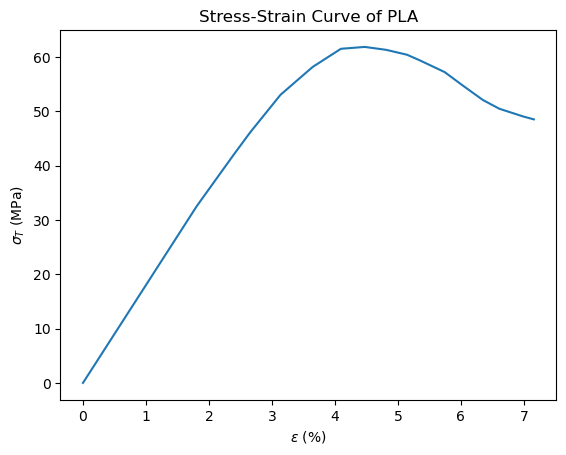

In [4]:
# Define Material
stress_strain = pd.read_excel('PLA stress-strain.xlsx')
plt.plot(stress_strain['x'], stress_strain['y (MPa)'])
plt.xlabel('$\epsilon$ (%)')
plt.ylabel('$\sigma_T$ (MPa)')
plt.title("Stress-Strain Curve of PLA")

In [5]:
stress_strain = stress_strain.iloc[:8]  # due to limitations of MISO model
stress_strain['y'] = stress_strain['y (MPa)']*1e6
stress_strain['x'] = stress_strain['x']/100
UTS = stress_strain['y'].max()
Youngs_Modulus = stress_strain['y'][1]/stress_strain['x'][1]
max_plastic_strain = stress_strain['x'].iloc[-1]

mapdl.mp('EX', 1, Youngs_Modulus)   # Young's Modulus in Pascals
mapdl.mp('PRXY', 1, 0.33)   # Poisson's Ratio

# Non linear 부분 정의
stress_strain['x'] = stress_strain['x'] - stress_strain['y']/Youngs_Modulus
mapdl.tb('PLASTIC', 1, '', 'MISO')
for i in range(len(stress_strain)):
    mapdl.tbpt(i, stress_strain['x'][i], stress_strain['y'][i])
    

In [6]:
mapdl.tblist(lab = 'ALL', mat=1)

LIST DATA TABLE  ALL   FOR MATERIAL      1

 *** MAPDL - ENGINEERING ANALYSIS SYSTEM  RELEASE 2024 R2          24.2     ***
 Ansys Mechanical Enterprise Academic Student      
 01055371  VERSION=WINDOWS x64   16:31:25  NOV 19, 2024 CP=      0.188

                                                                               



               PLASTIC  (PLAS) Table For Material     1
               ISOTROPIC HARDENING PLASTICITY                                                  

                     1 
 Temps     0.0000000e+00 
      PlStrain       Stress  
 0.0000000e+00 3.2562199e+07 
 6.0047983e-04 4.1927234e+07 
 9.4595014e-04 4.6167819e+07 
 1.9196673e-03 5.3057713e+07 
 4.1738999e-03 5.8177004e+07 
 6.8089990e-03 6.1528014e+07 
 1.0411409e-02 6.1872145e+07

In [7]:
# Specimen dimensions
length = 0.1       # Total length in meters
width = 0.02       # Width in meters
thickness = 0.005  # Thickness in meters

# Create a notched specimen for stress concentration
notch_depth = 0.005
notch_width = 0.005

# Main body
mapdl.block(0, length, -width/2, width/2, -thickness/2, thickness/2)

1

In [8]:
# Element type with plasticity capability (SOLID185 is suitable)
mapdl.et(1, 'SOLID185')

# Define mesh size
mapdl.esize(0.005)  # Smaller element size for better accuracy

# Mesh the volume
mapdl.vmesh('ALL')
mapdl.eplot()

Widget(value='<iframe src="http://localhost:11911/index.html?ui=P_0x1be0cf32bd0_0&reconnect=auto" class="pyvis…

## Simulation

In [9]:
mapdl.solution()

***** ROUTINE COMPLETED *****  CP =         0.234



 *****  MAPDL SOLUTION ROUTINE  *****

In [10]:
mapdl.antype('STATIC')
mapdl.nlgeom('ON')  # Enable large deformation effects

total_displacement = 0.01  # 10 mm total displacement
number_of_steps = 10
displacement_increment = total_displacement / number_of_steps

In [11]:
# mapdl.nropt('UNSYM')  # Use unsymmetric matrix if convergence issues occur
mapdl.autots('ON')    # Enable automatic time stepping
# mapdl.nliter(50, 0, 0, 0, 0)  # Set maximum number of equilibrium iterations
# mapdl.cnvtol('F', 0.1)  # Force convergence tolerance
mapdl.nsubst(20, 100, 1)
# mapdl.deltim(dtime = "AUTOTS", dtmin = 0, dtmax = 1)

USE      20 SUBSTEPS INITIALLY THIS LOAD STEP FOR ALL  DEGREES OF FREEDOM
 FOR AUTOMATIC TIME STEPPING:
   USE    100 SUBSTEPS AS A MAXIMUM
   USE      1 SUBSTEPS AS A MINIMUM

In [ ]:
# Initialize arrays to store results
reaction_forces = []
applied_displacements = []

for step in range(1, number_of_steps + 1):
    current_disp = displacement_increment * step
    mapdl.ddele('ALL', 'UX')  # Remove previous displacement BC
    mapdl.nsel('S', 'LOC', 'X', length)
    mapdl.d('ALL', 'UX', current_disp)
    mapdl.d("ALL", "UY", 0)
    mapdl.d("ALL", "UZ", 0)
    mapdl.nsel('S', 'LOC', 'X', 0)
    mapdl.d("ALL", "ALL", 0)
    mapdl.nsel('ALL')
    
    # Solve current load step
    mapdl.solve()
    
    # Post-process to check for failure criterion
    mapdl.post1()
    mapdl.set('LAST')
    
    # Get nodal principal stress
    mapdl.nsel('ALL')
    mapdl.nsel('S', 'LOC', 'X', vmin=0.4*length, vmax=0.6*length)
    principal_stress = np.maximum.reduce([mapdl.post_processing.nodal_principal_stress("1"),
                  mapdl.post_processing.nodal_principal_stress("2"),
                  mapdl.post_processing.nodal_principal_stress("3")])


    mapdl.nsel('ALL')
    mapdl.nsel('S', 'LOC', 'X', 0)

    reaction_forces_selected = mapdl.prrsol('FX').to_dataframe(columns=["NODE", "FX"])
    reaction_force = abs(reaction_forces_selected['FX'].sum())

    # Get the reaction forces from the result object
    # result = mapdl.result
    # # 이거를 result 안쓰고 하는 법 없나? result 문법을 잘 모르겠음
    # nnum, reaction_force = result.nodal_static_forces(0)
    # mapdl.nsel('ALL')
    # mapdl.nsel('S', 'LOC', 'X', 0)
    # selected_nodes = mapdl.mesh.nnum  # Node numbers in the current selection
    # reaction_force = reaction_force[selected_nodes-1].sum(axis=0)[0]
    
    reaction_forces.append(reaction_force)
    applied_displacements.append(current_disp)

    if (principal_stress > UTS).sum() > 0:
        print("Specimen failed")
        break

    mapdl.solution()

## Result

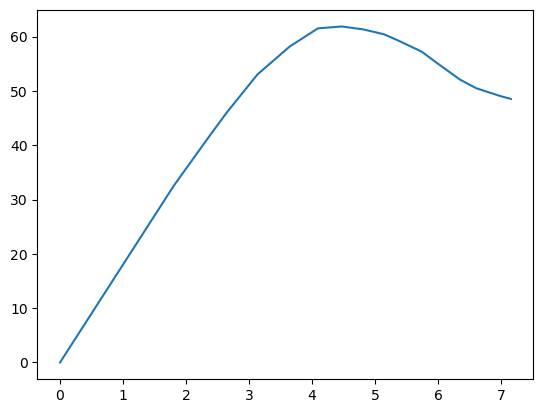

In [13]:
stress_strain = pd.read_excel('PLA stress-strain.xlsx')
plt.plot(stress_strain['x'], stress_strain['y (MPa)'])
plt.plot(np.array(applied_displacements)/length*100, np.array(reaction_forces)/width/thickness/1e6)

In [14]:
# Select nodes of interest (e.g., where X = 0)
mapdl.nsel("ALL")
mapdl.nsel("S", "LOC", "X", 0)

# Retrieve reaction forces for selected nodes
reaction_forces_selected = mapdl.prrsol('FX').to_dataframe(columns=["NODE", "FX"])
abs(reaction_forces_selected['FX'].sum())

1801.6399999999999

In [15]:
result = mapdl.result
result.plot_nodal_displacement(
    0,
    cpos="xy",
    displacement_factor=10,
    show_displacement=True,
    show_edges=True,
)

Widget(value='<iframe src="http://localhost:11911/index.html?ui=P_0x1be0eda74d0_1&reconnect=auto" class="pyvis…

In [16]:
result.plot_principal_nodal_stress(
    0,
    "SEQV",
    cpos="xy",
    background="w",
    text_color="k",
    add_text=True,
    show_edges=True,
)

Widget(value='<iframe src="http://localhost:11911/index.html?ui=P_0x1be1c34bd90_2&reconnect=auto" class="pyvis…

In [17]:
mapdl.eplot()

Widget(value='<iframe src="http://localhost:11911/index.html?ui=P_0x1be1c339450_3&reconnect=auto" class="pyvis…

In [18]:
nnum, stress_result = result.principal_nodal_stress(0)
stress_result = stress_result[:, -1]

In [19]:
# mapdl.nsel("ALL")
# # Get all node numbers
# node_numbers = mapdl.mesh.nnum

# # Initialize lists to store coordinates
# x_coords, y_coords, z_coords = [], [], []

# # Loop through node numbers and query coordinates
# for node in node_numbers:
#     x_coords.append(mapdl.get(entity="node", entnum=node, item1="loc", it1num="x"))
#     y_coords.append(mapdl.get(entity="node", entnum=node, item1="loc", it1num="y"))
#     z_coords.append(mapdl.get(entity="node", entnum=node, item1="loc", it1num="z"))

# # Combine node numbers and coordinates
# node_data = np.column_stack((x_coords, y_coords, z_coords))

In [20]:
# from mpl_toolkits.mplot3d import Axes3D

# x_coords = node_data[:, 0]
# y_coords = node_data[:, 1]
# z_coords = node_data[:, 2]

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection="3d")
# sc = ax.scatter(x_coords, y_coords, z_coords, c=abs(stress_result), cmap="coolwarm", s=50)
# plt.colorbar(sc, label = "Stres (MPa)")
# ax.set_xlabel("X Coordinate (m)")
# ax.set_ylabel("Y Coordinate (m)")
# ax.set_zlabel("Z Coordinate (m)")
# ax.set_title("3D Nodal Displacement Visualization")
# plt.axis('equal')
# plt.show()

In [21]:
# Reaction force 구하는 법 (다 하자 있음)

# Option 1
nnum, reaction_forces = result.nodal_static_forces(0)
mapdl.allsel()
mapdl.nsel('S', 'LOC', 'X', 0)
selected_nodes = mapdl.mesh.nnum  # Node numbers in the current selection
reaction_forces[selected_nodes-1].sum(axis=0)[0]

# Option 2
total_reaction_force_x = 0.0
total_reaction_force_y = 0.0
total_reaction_force_z = 0.0

mapdl.nsel('S', 'LOC', 'X', 0)
# Get list of selected nodes
selected_nodes = mapdl.mesh.nnum  # Node numbers in the current selection

# Loop over nodes to sum reaction forces
for node in selected_nodes:
    rfx = mapdl.get_value(entity='NODE', entnum=node, item1='RF', it1num='X')
    rfy = mapdl.get_value(entity='NODE', entnum=node, item1='RF', it1num='Y')
    rfz = mapdl.get_value(entity='NODE', entnum=node, item1='RF', it1num='Z')

    total_reaction_force_x += rfx
    total_reaction_force_y += rfy
    total_reaction_force_z += rfz
print(total_reaction_force_x)
print(total_reaction_force_y)
print(total_reaction_force_z)

310.0
310.0
310.0


## Load & View Result

In [4]:
import os

current_dir = os.getcwd()

In [24]:
mapdl.save(fname=f"{current_dir}/result/result_iteration", ext="db")
# mapdl.run(f"FILE, {current_dir}/result/result_iteration, rst")
mapdl.reswrite(fname = f"{current_dir}/result/result_iteration")

PUT THIS LOAD CASE ON THE RESULT FILE d:\01__Personal_Projects\IIAD_pyMAPDL/result/result_iteration.rst
  AS RESULT SET     1 (LOAD STEP     1 SUBSTEP     7 TIME=  1.0000    )

In [5]:
mapdl.post1()  # Enter post-processing
mapdl.resume(fname=f"{current_dir}/result/result_iteration", ext="db");

In [9]:
result = pymapdl_reader.read_binary(f"{current_dir}/result/result_iteration.rst")

In [12]:
mapdl.exit()